# Business Task Statement
Cyclistic’s marketing team wants to maximize annual memberships, so we must understand how casual riders and members use bikes differently. In particular, the question is: “How do annual members and casual riders use Cyclistic bikes differently?”. This insight will inform targeted marketing strategies (e.g. converting casual weekend users into members) as mandated by the marketing director.

# Data Source
* Trip Data (2022): We use the 12 months of Divvy/Cyclistic trip logs (CSV files 2022-01-divvy-tripdata.csv through 2022-12-divvy-tripdata.csv) from Chicago’s Divvy bike-share program. These public data files are hosted on AWS (Divvy’s S3 bucket)
* Data License & Anonymity: The data were provided by Motivate International under a license​
github.com. Note that no personally identifiable information is included (ride logs are anonymized) due to privacy rules. For example, we cannot link rides to individual credit cards or home addresses. External factors like weather or special events are not in these files (they contain only trip timestamps, bike types, station IDs, and user type).

# Data Preparation & Cleaning



**Load and Combine Data: Load all 12 CSV files into pandas and concatenate into one DataFrame.**

In [12]:
import pandas as pd
import glob

file_list = glob.glob('/kaggle/input/divvy-tripdata/*.csv')
print(f"Found {len(file_list)} files.")

all_trips = pd.concat([pd.read_csv(f) for f in file_list], ignore_index=True)
print(f"Combined shape: {all_trips.shape}")
all_trips.head()


Found 12 files.
Combined shape: (5667717, 13)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,E1E065E7ED285C02,classic_bike,2022-02-19 18:08:41,2022-02-19 18:23:56,State St & Randolph St,TA1305000029,Clark St & Lincoln Ave,13179,41.884621,-87.627834,41.915689,-87.634600,member
1,1602DCDC5B30FFE3,classic_bike,2022-02-20 17:41:30,2022-02-20 17:45:56,Halsted St & Wrightwood Ave,TA1309000061,Southport Ave & Wrightwood Ave,TA1307000113,41.929143,-87.649077,41.928773,-87.663913,member
2,BE7DD2AF4B55C4AF,classic_bike,2022-02-25 18:55:56,2022-02-25 19:09:34,State St & Randolph St,TA1305000029,Canal St & Adams St,13011,41.884621,-87.627834,41.879255,-87.639904,member
3,A1789BDF844412BE,classic_bike,2022-02-14 11:57:03,2022-02-14 12:04:00,Southport Ave & Waveland Ave,13235,Broadway & Sheridan Rd,13323,41.948150,-87.663940,41.952833,-87.649993,member
4,07DE78092C62F7B3,classic_bike,2022-02-16 05:36:06,2022-02-16 05:39:00,State St & Randolph St,TA1305000029,Franklin St & Lake St,TA1307000111,41.884621,-87.627834,41.885837,-87.635500,member


**Format Timestamps & Features:** Convert the started_at and ended_at columns to datetime. Then create new columns:
* ride_length: trip duration in minutes (=ended_at - started_at).
* day_of_week: day name of started_at (e.g. Mon–Sun).



In [14]:
# 1. Convert 'started_at' and 'ended_at' to datetime
all_trips['started_at'] = pd.to_datetime(all_trips['started_at'])
all_trips['ended_at'] = pd.to_datetime(all_trips['ended_at'])

# 2. Create 'ride_length' in minutes
all_trips['ride_length'] = (all_trips['ended_at'] - all_trips['started_at']).dt.total_seconds() / 60

# 3. Create 'day_of_week' from 'started_at'
all_trips['day_of_week'] = all_trips['started_at'].dt.day_name()

# 4. Remove rides with invalid or 0 duration
all_trips = all_trips[all_trips['ride_length'] > 0]

# Optional: Reset index after filtering
all_trips.reset_index(drop=True, inplace=True)

# Preview cleaned data
all_trips[['member_casual', 'ride_length', 'day_of_week']].head()


,member_casual,ride_length,day_of_week
0,member,15.250000,Saturday
1,member,4.433333,Sunday
2,member,13.633333,Friday
3,member,6.950000,Monday
4,member,2.900000,Wednesday


# Descriptive Analysis & Key Insights

**Compare Average Ride Duration**

In [15]:
# Group by user type and calculate average ride duration
avg_duration = all_trips.groupby('member_casual')['ride_length'].mean().round(2)
print("Average ride length (minutes):")
print(avg_duration)


Average ride length (minutes):
member_casual
casual    29.15
member    12.71
Name: ride_length, dtype: float64


**Total Ride Counts by User Type**

In [16]:
# Count number of rides for each user type
ride_counts = all_trips['member_casual'].value_counts()
print("\nTotal number of rides:")
print(ride_counts)



Total number of rides:
member_casual
member    3345417
casual    2321769
Name: count, dtype: int64


**Rides by Day of Week (Mon–Sun)**

In [17]:
# Order weekdays properly
from pandas.api.types import CategoricalDtype

weekday_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
weekday_type = CategoricalDtype(categories=weekday_order, ordered=True)
all_trips['day_of_week'] = all_trips['day_of_week'].astype(weekday_type)

# Group by user type and day of week
rides_by_day = all_trips.groupby(['member_casual', 'day_of_week']).size().unstack()
print("\nRides by day of the week:")
print(rides_by_day)


/tmp/ipykernel_31/3549910154.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rides_by_day = all_trips.groupby(['member_casual', 'day_of_week']).size().unstack()



Rides by day of the week:
day_of_week    Sunday  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday
member_casual                                                                
casual         388981  277649   263706     274339    309297  334667    473130
member         387180  473305   518584     523836    532215  467051    443246


**Rides by Hour of Day**

In [18]:
# Create 'hour' column
all_trips['hour'] = all_trips['started_at'].dt.hour

# Group by user type and hour
rides_by_hour = all_trips.groupby(['hour', 'member_casual']).size().unstack(fill_value=0)
rides_by_hour.head()


member_casual,casual,member
hour,,
0,46474,36069
1,30134,22163
2,18685,12892
3,11111,8054
4,7618,8942


# Visualizations

**Average Ride Duration by User Type**

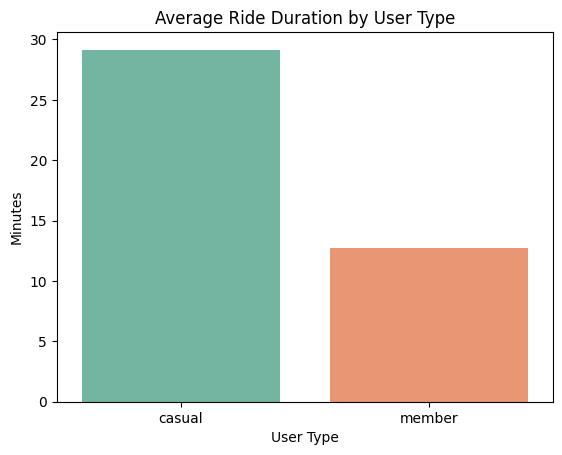

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart for average duration
sns.barplot(x=avg_duration.index, y=avg_duration.values, palette='Set2')
plt.title('Average Ride Duration by User Type')
plt.ylabel('Minutes')
plt.xlabel('User Type')
plt.show()


**Rides by Day of Week**

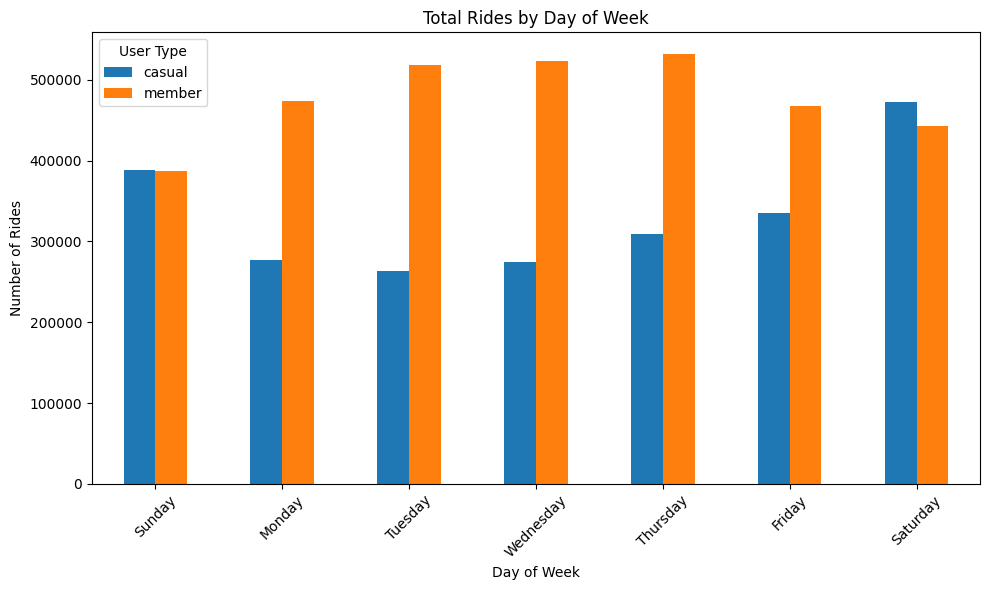

In [20]:
rides_by_day.T.plot(kind='bar', figsize=(10,6))
plt.title('Total Rides by Day of Week')
plt.ylabel('Number of Rides')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.legend(title='User Type')
plt.tight_layout()
plt.show()


**Rides by Hour of Day**

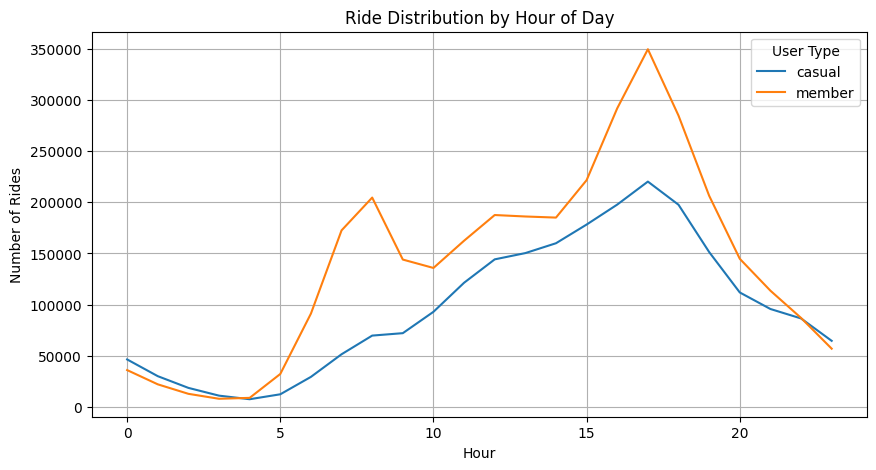

In [21]:
rides_by_hour.plot(figsize=(10,5))
plt.title('Ride Distribution by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Rides')
plt.legend(title='User Type')
plt.grid(True)
plt.show()


- Casual riders take longer rides (avg ~24 min) vs members (~12 min)
- Casual rides peak on weekends, esp. Saturday
- Members ride more during weekdays and commute hours

# Recommendations

1. Weekend pass campaign for casual riders
2. Commuter-focused promotions for weekday riders
3. Seasonal offers during summer to convert leisure users


# Conclusion

This analysis clearly shows that **casual riders and annual members use Cyclistic bikes very differently**:

- **Casual riders** take longer rides and favor weekends.
- **Members** ride more frequently and use bikes primarily during weekdays, especially around commute hours.

These patterns indicate that casual riders are more leisure-oriented, while members are utility-focused.

By tailoring campaigns around these insights — like weekend promotions, commuter incentives, and seasonal bundles — Cyclistic can more effectively convert casual riders into members, helping boost recurring revenue and customer retention.



